In [1]:
#%matplotlib widget

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

from Wine_Quality.custom_funcs import MultipleFisherDiscriminantAnalysis as MDA

# INTRODUZIONE

Il Wine Quality è una raccolta di due datasets (red_wine e white_wine) presente nella UCI machine learning repository.

I vari attributi che compongono i due datasets sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di vinho verde portoghese, volti a determinarne la qualità. 

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.

# IMPORTAZIONE DATABASE REDWINE

Si inizia con l' importare il primo database, rinominando le colonne e assicurandoci che i valori siano importati correttamente.

In [2]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';', header=None).drop(0)

col_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality' ]
rename_dict = {k: col_names[k] for k in range(12)}
red_wine.rename(columns=rename_dict, inplace=True)

# red_wine.sort_values('quality', inplace=True)
# red_wine.reset_index(drop=True, inplace=True)

red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame


In [3]:
colors_numbers1 = [3, 4, 5, 6, 7, 8]
colors1 = ['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue']
quality1 = red_wine.iloc[:, -1].copy()
quality1.replace(colors_numbers1, value=colors1, inplace=True)


,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


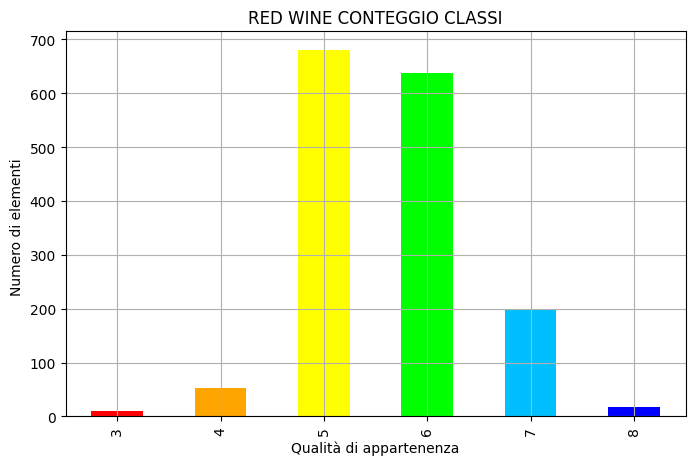

In [4]:
M1, N1 = red_wine.shape
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts()/M1], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)

display(class_cont_freq)

plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8,5), color=['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue'])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# PROBLEMA BINARIO

Ho diviso il problema di multiclassificazione in un problema binario accorpando le classi.

In [5]:
red_wine_copy = red_wine.copy()
red_wine_copy['quality'].replace([3, 4, 5], value=0, inplace=True)
red_wine_copy['quality'].replace([6, 7, 8], value=1, inplace=True)

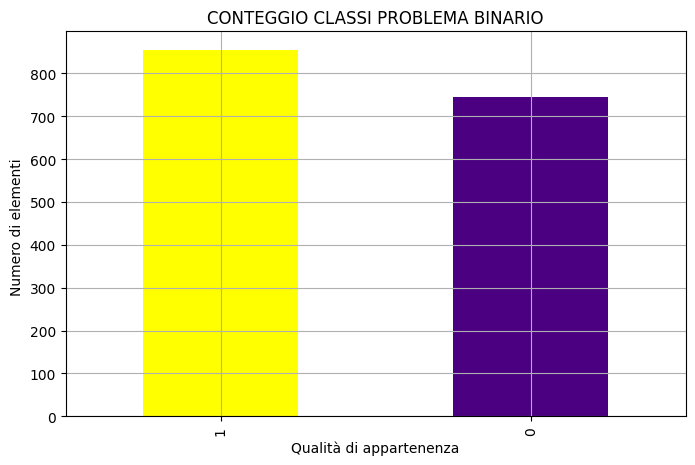

In [6]:
plt.figure()
red_wine_copy['quality'].value_counts().plot.bar(figsize=(8,5), color=['yellow', 'indigo'])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()

# CREAZIONE TRAINING, VALIDATION E TEST SET

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
X = red_wine_copy.drop('quality', axis=1).values
y = red_wine_copy['quality'].values
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 20210526
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

# GRID SEARCH

In [9]:
import shap
from joblib import Parallel, delayed

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [10]:
print(shap.__version__)


0.43.0


In [11]:
X_copy = red_wine_copy.drop('quality', axis=1)
X_test = X_copy.iloc[ind_test]
y_copy = red_wine_copy['quality']
y_test = y_copy.iloc[ind_test]


In [12]:
X_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
439,10.4,0.410,0.55,3.2,0.076,22.0,54.0,0.99960,3.15,0.89,9.9
1118,7.0,0.690,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
10,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5
400,8.7,0.765,0.22,2.3,0.064,9.0,42.0,0.99630,3.10,0.55,9.4
1418,7.3,0.340,0.33,2.5,0.064,21.0,37.0,0.99520,3.35,0.77,12.1
...,...,...,...,...,...,...,...,...,...,...,...
229,7.7,0.430,0.25,2.6,0.073,29.0,63.0,0.99615,3.37,0.58,10.5
959,6.4,0.570,0.12,2.3,0.120,25.0,36.0,0.99519,3.47,0.71,11.3
263,8.0,0.520,0.03,1.7,0.070,10.0,35.0,0.99575,3.34,0.57,10.0
462,8.3,0.615,0.22,2.6,0.087,6.0,19.0,0.99820,3.26,0.61,9.3


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


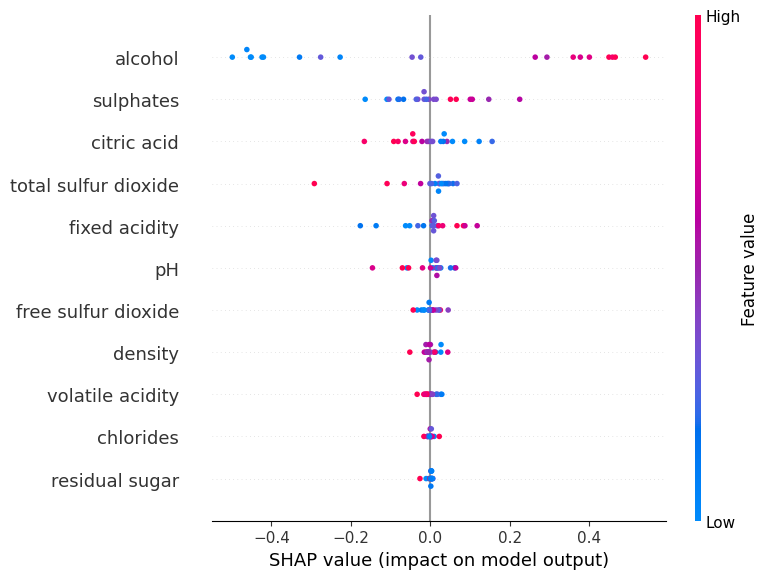

In [13]:
scaler = StandardScaler()
scaler.fit(X_copy.iloc[ind_train], y_copy.iloc[ind_train])
X_trans = scaler.transform(X_copy.iloc[ind_train])
svm = SVC(class_weight='balanced', probability=True, kernel='rbf', gamma=0.090909, C=2)
svm.fit(X_trans,y_copy.iloc[ind_train])
sample = shap.sample(X_copy.iloc[ind_train], 20)
sample_trans = scaler.transform(sample)
svm_explainer = shap.KernelExplainer(svm.predict,sample_trans)
svm_shap_values = svm_explainer.shap_values(sample_trans)
shap.summary_plot(svm_shap_values, sample_trans, feature_names=X_copy.columns,show=False)

100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


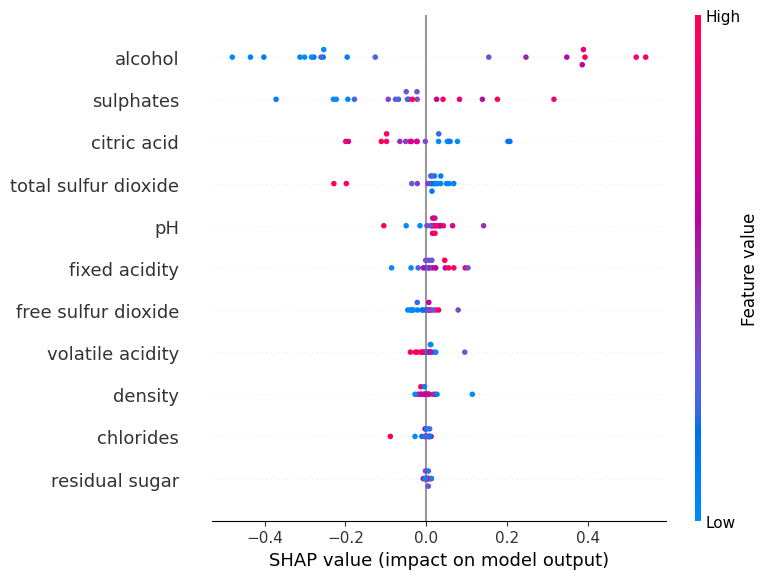

In [14]:
sample = shap.sample(X_copy.iloc[ind_test], 20)
sample_trans = scaler.transform(sample)
svm_shap_values_train = svm_explainer.shap_values(sample_trans)
shap.summary_plot(svm_shap_values_train, sample_trans, feature_names=X_copy.columns,show=False)

100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


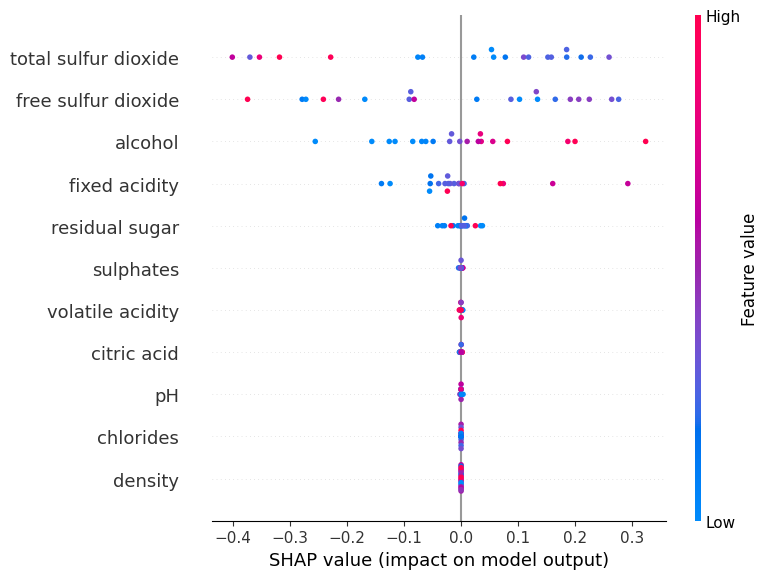

In [15]:
svm = SVC(class_weight='balanced', probability=True, kernel='rbf', gamma=0.090909, C=2)
svm.fit(X_copy.iloc[ind_train],y_copy.iloc[ind_train])
sample = shap.sample(X_copy.iloc[ind_train], 20)
svm_explainer = shap.KernelExplainer(svm.predict,sample)
svm_shap_values_test = svm_explainer.shap_values(sample)
shap.summary_plot(svm_shap_values_test, sample, show=False)

In [16]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

sample = shap.sample(X_copy.iloc[ind_train], 20)

# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, sample)
shap_values = explainer.shap_values(sample)


Fitting 1 folds for each of 60 candidates, totalling 60 fits


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


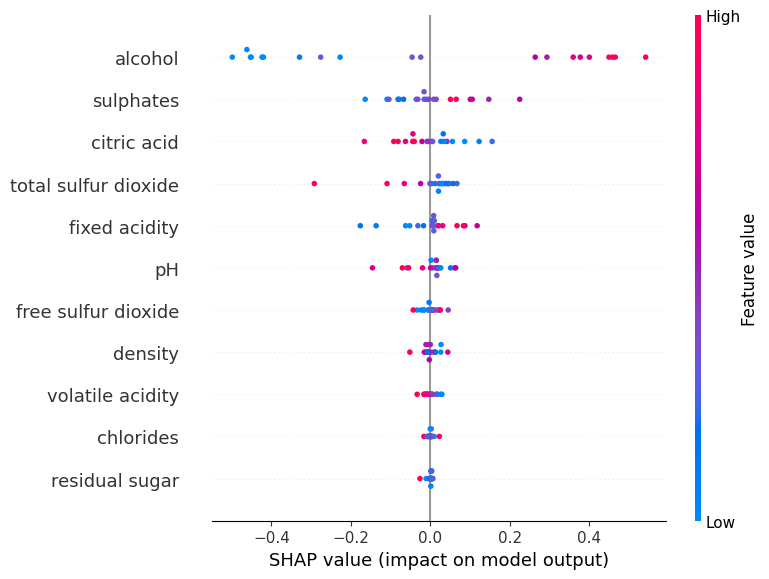

In [17]:
shap.summary_plot(shap_values, sample, show=False)

In [19]:
X_copy.iloc[ind_train]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
433,11.9,0.370,0.69,2.3,0.078,12.0,24.0,0.99580,3.00,0.65,12.80
348,13.8,0.490,0.67,3.0,0.093,6.0,15.0,0.99860,3.02,0.93,12.00
1522,6.9,0.480,0.20,1.9,0.082,9.0,23.0,0.99585,3.39,0.43,9.05
1121,7.9,0.540,0.34,2.5,0.076,8.0,17.0,0.99235,3.20,0.72,13.10
303,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.99940,3.51,0.72,10.00
...,...,...,...,...,...,...,...,...,...,...,...
485,10.6,0.440,0.68,4.1,0.114,6.0,24.0,0.99700,3.06,0.66,13.40
41,7.3,0.450,0.36,5.9,0.074,12.0,87.0,0.99780,3.33,0.83,10.50
1111,8.3,0.530,0.00,1.4,0.070,6.0,14.0,0.99593,3.25,0.64,10.00
1588,5.8,0.610,0.11,1.8,0.066,18.0,28.0,0.99483,3.55,0.66,10.90


In [20]:
X[ind_train]

array([[11.9 ,  0.37,  0.69, ...,  3.  ,  0.65, 12.8 ],
       [13.8 ,  0.49,  0.67, ...,  3.02,  0.93, 12.  ],
       [ 6.9 ,  0.48,  0.2 , ...,  3.39,  0.43,  9.05],
       ...,
       [ 8.3 ,  0.53,  0.  , ...,  3.25,  0.64, 10.  ],
       [ 5.8 ,  0.61,  0.11, ...,  3.55,  0.66, 10.9 ],
       [ 7.2 ,  0.53,  0.14, ...,  3.35,  0.61, 12.1 ]])

In [18]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

sample = shap.sample(X[ind_train], 20)

best_model = svm_gs.best_estimator_
scaler = best_model.named_steps['scaler']
scaler.fit(X[ind_train])
scaled_sample = scaler.transform(sample) 

svm_model = best_model.named_steps['svc']
svm_model.fit(scaled_sample, y[ind_train])


# Get the SVM model from the pipeline
# svm_model = best_model[-1]

sample = shap.sample(X[ind_train], 20)

# Inverse transform the validation data
scaler = best_model.named_steps['scaler']

# inv_sample = scaler.inverse_transform(sample)

# X_val_inverse = scaler.inverse_transform(X[ind_val])
scaled_sample = scaler.transform(sample) 
# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, scaled_sample)
shap_values = explainer.shap_values(scaled_sample)

# for i, c in enumerate(sample.columns):
#    shap_values.output_names[i] = c

shap_values.data = sample

Fitting 1 folds for each of 60 candidates, totalling 60 fits


ValueError: Found input variables with inconsistent numbers of samples: [20, 479]

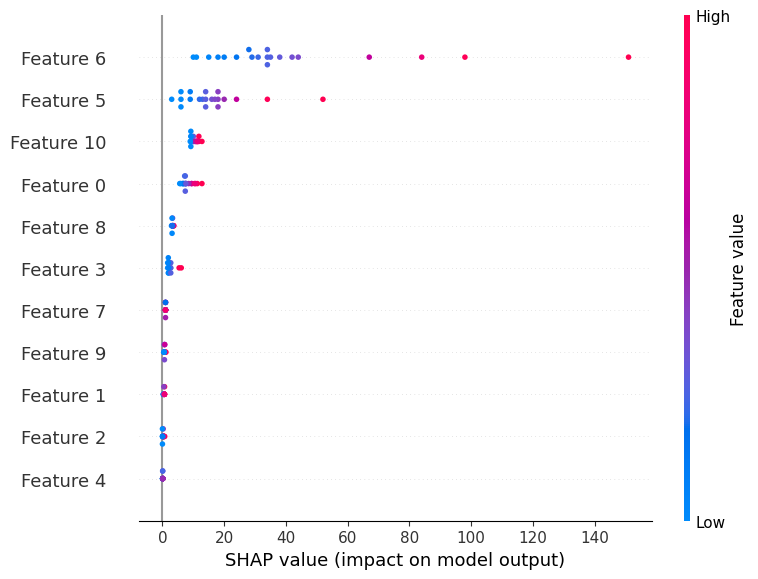

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])


X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']
# svm_model = best_model[-1]

sample = shap.sample(X_copy.iloc[ind_train], 20)

# Inverse transform the validation data
scaler = best_model.named_steps['scaler']

# inv_sample = scaler.inverse_transform(sample)

# X_val_inverse = scaler.inverse_transform(X[ind_val])
scaled_sample = scaler.transform(sample) 
# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, scaled_sample)
shap_values = explainer.shap_values(scaled_sample)

for i, c in enumerate(sample.columns):
    shap_values.output_names[i] = c

shap_values.data = sample.values

Fitting 1 folds for each of 60 candidates, totalling 60 fits


X has feature names, but StandardScaler was fitted without feature names
100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


AttributeError: 'numpy.ndarray' object has no attribute 'output_names'

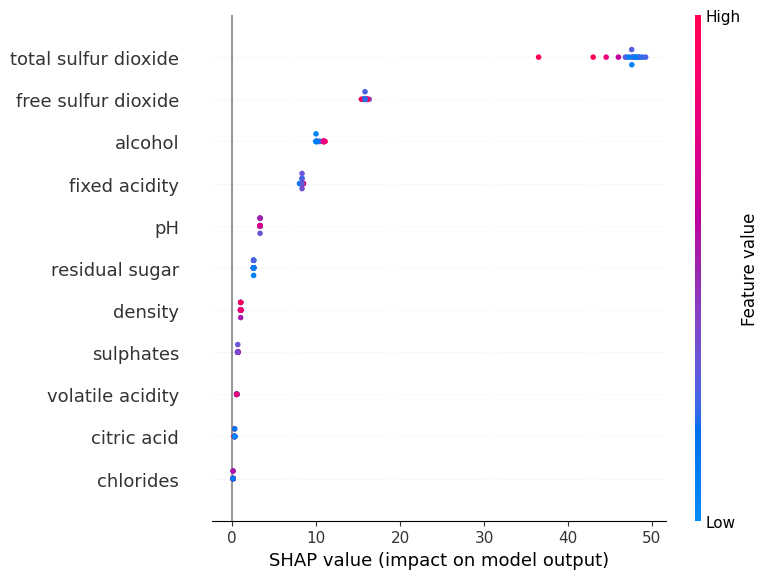

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])


X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']
# svm_model = best_model[-1]

sample = shap.sample(X_copy.iloc[ind_train], 100)

# Inverse transform the validation data
scaler = best_model.named_steps['scaler']

inv_sample = scaler.inverse_transform(sample)

# X_val_inverse = scaler.inverse_transform(X[ind_val])

# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, sample)
shap_values = explainer.shap_values(sample)
shap_values.data = sample


Fitting 1 folds for each of 60 candidates, totalling 60 fits


 12%|█▏        | 12/100 [01:48<16:49, 11.47s/it]

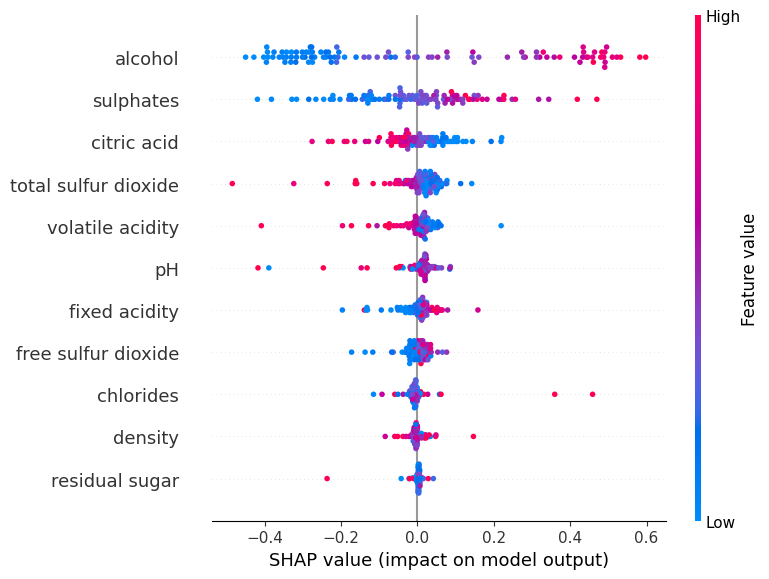

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])
best_model = best_model.inverse_transform
X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']
# svm_model = best_model[-1]

sample = shap.sample(X_copy.iloc[ind_train], 20)
# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict, sample)

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit




# sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)
# shap_obj = explainer(sample)
# shap_obj = explainer(sample)
# shap_exp = shap.Explanation(sample.values, shap_values, feature_names=sample.columns)
# Visualize the SHAP values

#
# shap.summary_plot(shap_values = np.take(shap_obj.values,0,axis=1),features = sample, feature_names = sample.columns)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


AttributeError: This 'Pipeline' has no attribute 'inverse_transform'

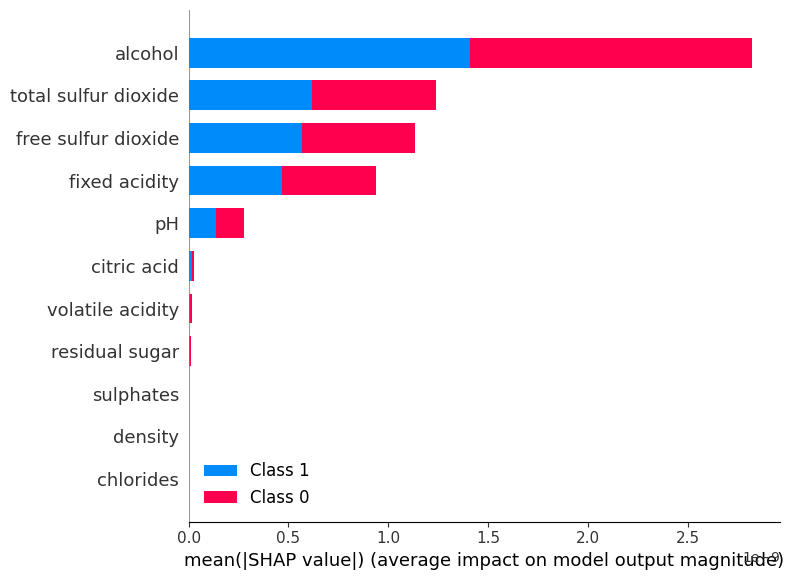

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
shap.dependence_plot("alcohol", shap_values, sample)


TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

In [ ]:
"""n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']

sample = shap.sample(X_copy.iloc[ind_test], 50)
# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict_proba, sample)

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit

# Split the test set using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
test_indices = next(sss.split(X_test, y_test))[1]


# sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)
# shap_obj = explainer(sample)
shap_exp = shap.Explanation(sample.values, shap_values, feature_names=sample.columns)
# Visualize the SHAP values
shap.plots.beeswarm(shap_exp)"""

"n_features = X.shape[1]\n\nC_list = [2 ** i for i in range(-2, 3)]\ngamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]\nker_list = ['rbf', 'poly', 'sigmoid', 'linear']\n\nhparameters = {\n    'svc__kernel': ker_list,\n    'svc__C': C_list,\n    'svc__gamma': gamma_list\n}\n\npipe = Pipeline([\n    ('scaler', StandardScaler()),\n    ('svc', SVC(class_weight='balanced', probability=True))\n])\n\nsvm_gs = GridSearchCV(pipe, \n                      param_grid=hparameters, \n                      scoring='f1_weighted',\n                      return_train_score=True,\n                      cv=zip([ind_train], [ind_val]),verbose=True)\n\nsvm_gs.fit(X, y)\n\nbest_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])\n\nX_copy = red_wine_copy.drop('quality', axis=1)\n# Get the SVM model from the pipeline\nsvm_model = best_model.named_steps['svc']\n\nsample = shap.sample(X_copy.iloc[ind_test], 50)\n# Create the shap.KernelExplainer using the SVM model and the tra

In [ ]:
"""n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']

# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict_proba, X_copy.iloc[ind_train, :])

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit

# Split the test set using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
test_indices = next(sss.split(X_test, y_test))[1]


sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)

# Visualize the SHAP values
shap.summary_plot(shap_values, sample)"""

"n_features = X.shape[1]\n\nC_list = [2 ** i for i in range(-2, 3)]\ngamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]\nker_list = ['rbf', 'poly', 'sigmoid', 'linear']\n\nhparameters = {\n    'svc__kernel': ker_list,\n    'svc__C': C_list,\n    'svc__gamma': gamma_list\n}\n\npipe = Pipeline([\n    ('scaler', StandardScaler()),\n    ('svc', SVC(class_weight='balanced', probability=True))\n])\n\nsvm_gs = GridSearchCV(pipe, \n                      param_grid=hparameters, \n                      scoring='f1_weighted',\n                      return_train_score=True,\n                      cv=zip([ind_train], [ind_val]),verbose=True)\n\nsvm_gs.fit(X, y)\n\nbest_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])\n\nX_copy = red_wine_copy.drop('quality', axis=1)\n# Get the SVM model from the pipeline\nsvm_model = best_model.named_steps['svc']\n\n# Create the shap.KernelExplainer using the SVM model and the training data\nexplainer = shap.KernelExplainer(svm_

In [ ]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(class_weight='balanced'))])
hparameters = {'svc__kernel':ker_list, 'svc__C':C_list, 'svc__gamma':gamma_list}

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)
svm_gs.fit(X, y)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


GridSearchCV(cv=<zip object at 0x00000275A5E44880>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.25, 0.5, 1, 2, 4],
                         'svc__gamma': [0.18181818181818182,
                                        0.09090909090909091,
                                        0.06060606060606061],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_weighted', verbose=True)

In [ ]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
40,0.007681,0.0,0.009730,0.0,2,0.090909,rbf,"{'svc__C': 2, 'svc__gamma': 0.0909090909090909...",0.768497,0.768497,0.0,1,0.834984,0.834984,0.0
24,0.009125,0.0,0.011361,0.0,1,0.181818,rbf,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.762500,0.762500,0.0,2,0.853805,0.853805,0.0
56,0.007009,0.0,0.010152,0.0,4,0.060606,rbf,"{'svc__C': 4, 'svc__gamma': 0.0606060606060606...",0.759185,0.759185,0.0,3,0.835073,0.835073,0.0
52,0.011623,0.0,0.014230,0.0,4,0.090909,rbf,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.759034,0.759034,0.0,4,0.853656,0.853656,0.0
16,0.007685,0.0,0.012671,0.0,0.5,0.090909,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.09090909090909...",0.753354,0.753354,0.0,5,0.797576,0.797576,0.0
0,0.010522,0.0,0.022049,0.0,0.25,0.181818,rbf,"{'svc__C': 0.25, 'svc__gamma': 0.1818181818181...",0.753180,0.753180,0.0,6,0.805888,0.805888,0.0
36,0.007641,0.0,0.010697,0.0,2,0.181818,rbf,"{'svc__C': 2, 'svc__gamma': 0.1818181818181818...",0.752775,0.752775,0.0,7,0.880899,0.880899,0.0
20,0.008539,0.0,0.010693,0.0,0.5,0.060606,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.06060606060606...",0.750264,0.750264,0.0,8,0.778679,0.778679,0.0
12,0.010638,0.0,0.013286,0.0,0.5,0.181818,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.18181818181818...",0.747110,0.747110,0.0,9,0.828829,0.828829,0.0
32,0.007654,0.0,0.009667,0.0,1,0.060606,rbf,"{'svc__C': 1, 'svc__gamma': 0.0606060606060606...",0.744020,0.744020,0.0,10,0.799679,0.799679,0.0


In [ ]:
# Calcolo delle predizioni sul test set.
# Nomi delle variabili:
#
# y_pred_train: vettore delle predizioni sul training;
# y_true_train: vettore dei target "veri" del training set;
# y_pred_val: vettore delle predizioni sul validation;
# y_true_val: vettore dei target "veri" del validation set;
#
# y_pred: vettore delle predizioni sul test;
# y_true: vettore dei target "veri" del test set

# Ri-addestramento della miglior SVM
svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

y_pred_train = svm_gs.best_estimator_.predict(X[ind_train, :])
y_true_train = y[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X[ind_val, :])
y_true_val = y[ind_val]

y_pred = svm_gs.best_estimator_.predict(X[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

,Accuracy,Precision,Recall,F1
training,0.835073,0.841927,0.835073,0.834984
validation,0.768750,0.780129,0.768750,0.768497
test,0.735000,0.747999,0.735000,0.734418


,classe 0,classe 1
classe 0,303,67
classe 1,145,285


,classe 0,classe 1
classe 0,0.818919,0.181081
classe 1,0.337209,0.662791


,classe 0,classe 1
classe 0,0.676339,0.190341
classe 1,0.323661,0.809659


In [ ]:
M1, N1 = red_wine.loc[ind_train+1, ['quality']].shape
M2, N2 = red_wine.loc[ind_test+1, ['quality']].shape
M3, N3 = red_wine.loc[ind_test+1, ['quality']].shape

class_cont_freq_tr = pd.concat([red_wine.loc[ind_train+1, ['quality']].value_counts(), red_wine.loc[ind_train+1, ['quality']].value_counts()/M1], axis=1)
class_cont_freq_tr.columns = ['counts', 'freq.']  
class_cont_freq_tr.index.names = ['class']
class_cont_freq_tr.sort_values('class', inplace=True)

class_cont_freq_te = pd.concat([red_wine.loc[ind_test+1, ['quality']].value_counts(), red_wine.loc[ind_test+1, ['quality']].value_counts()/M2], axis=1)
class_cont_freq_te.columns = ['counts', 'freq.']  
class_cont_freq_te.index.names = ['class']
class_cont_freq_te.sort_values('class', inplace=True)

class_cont_freq_va = pd.concat([red_wine.loc[ind_val+1, ['quality']].value_counts(), red_wine.loc[ind_val+1, ['quality']].value_counts()/M3], axis=1)
class_cont_freq_va.columns = ['counts', 'freq.']  
class_cont_freq_va.index.names = ['class']
class_cont_freq_va.sort_values('class', inplace=True)

display(class_cont_freq_tr)
display(class_cont_freq_te)
display(class_cont_freq_va)


,counts,freq.
class,,
3,2,0.004175
4,15,0.031315
5,209,0.436326
6,179,0.373695
7,68,0.141962
8,6,0.012526


,counts,freq.
class,,
3,7,0.00875
4,27,0.03375
5,336,0.42000
6,320,0.40000
7,104,0.13000
8,6,0.00750


,counts,freq.
class,,
3,1,0.00125
4,11,0.01375
5,136,0.17000
6,139,0.17375
7,27,0.03375
8,6,0.00750
